# Traffic Sign Classification Using CNNs

**Goal:** Design a CNN to classify traffic signs from the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

In addition to this Jupyter notebook, there is also a [writeup](./writeup.md) explaining more of the background and logic behind this network architecture and performance

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

---
## Load The Data

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

In [1]:
# Load pickled data
import pickle
import csv
import numpy as np

training_file = "../data/train.p"
validation_file= "../data/valid.p"
testing_file = "../data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']
n_classes = np.unique(y_train).shape[0]

# Create dict to convert class number to human-readable form
reader = csv.reader(open('signnames.csv'))
next(reader)  # Skip CSV header
class_name = {}
for row in reader:
    class_name[int(row[0])] = row[1]

print()
print("Image Shape:       {}".format(X_train[0].shape))
print("Training Set:      {} samples".format(len(X_train)))
print("Validation Set:    {} samples".format(len(X_valid)))
print("Test Set:          {} samples".format(len(X_test)))
print("Number of classes: {}".format(n_classes))


Image Shape:       (32, 32, 3)
Training Set:      34799 samples
Validation Set:    4410 samples
Test Set:          12630 samples
Number of classes: 43


## Dataset Summary & Exploration

Before diving into the model, it is important to familiarize yourself with the data being processed.  Below are a random selection of training images, along with their human-readable labels.  We also visualize the distribution of classes in the training data.  The distribution is very un-even so it may benefit from data augmentation

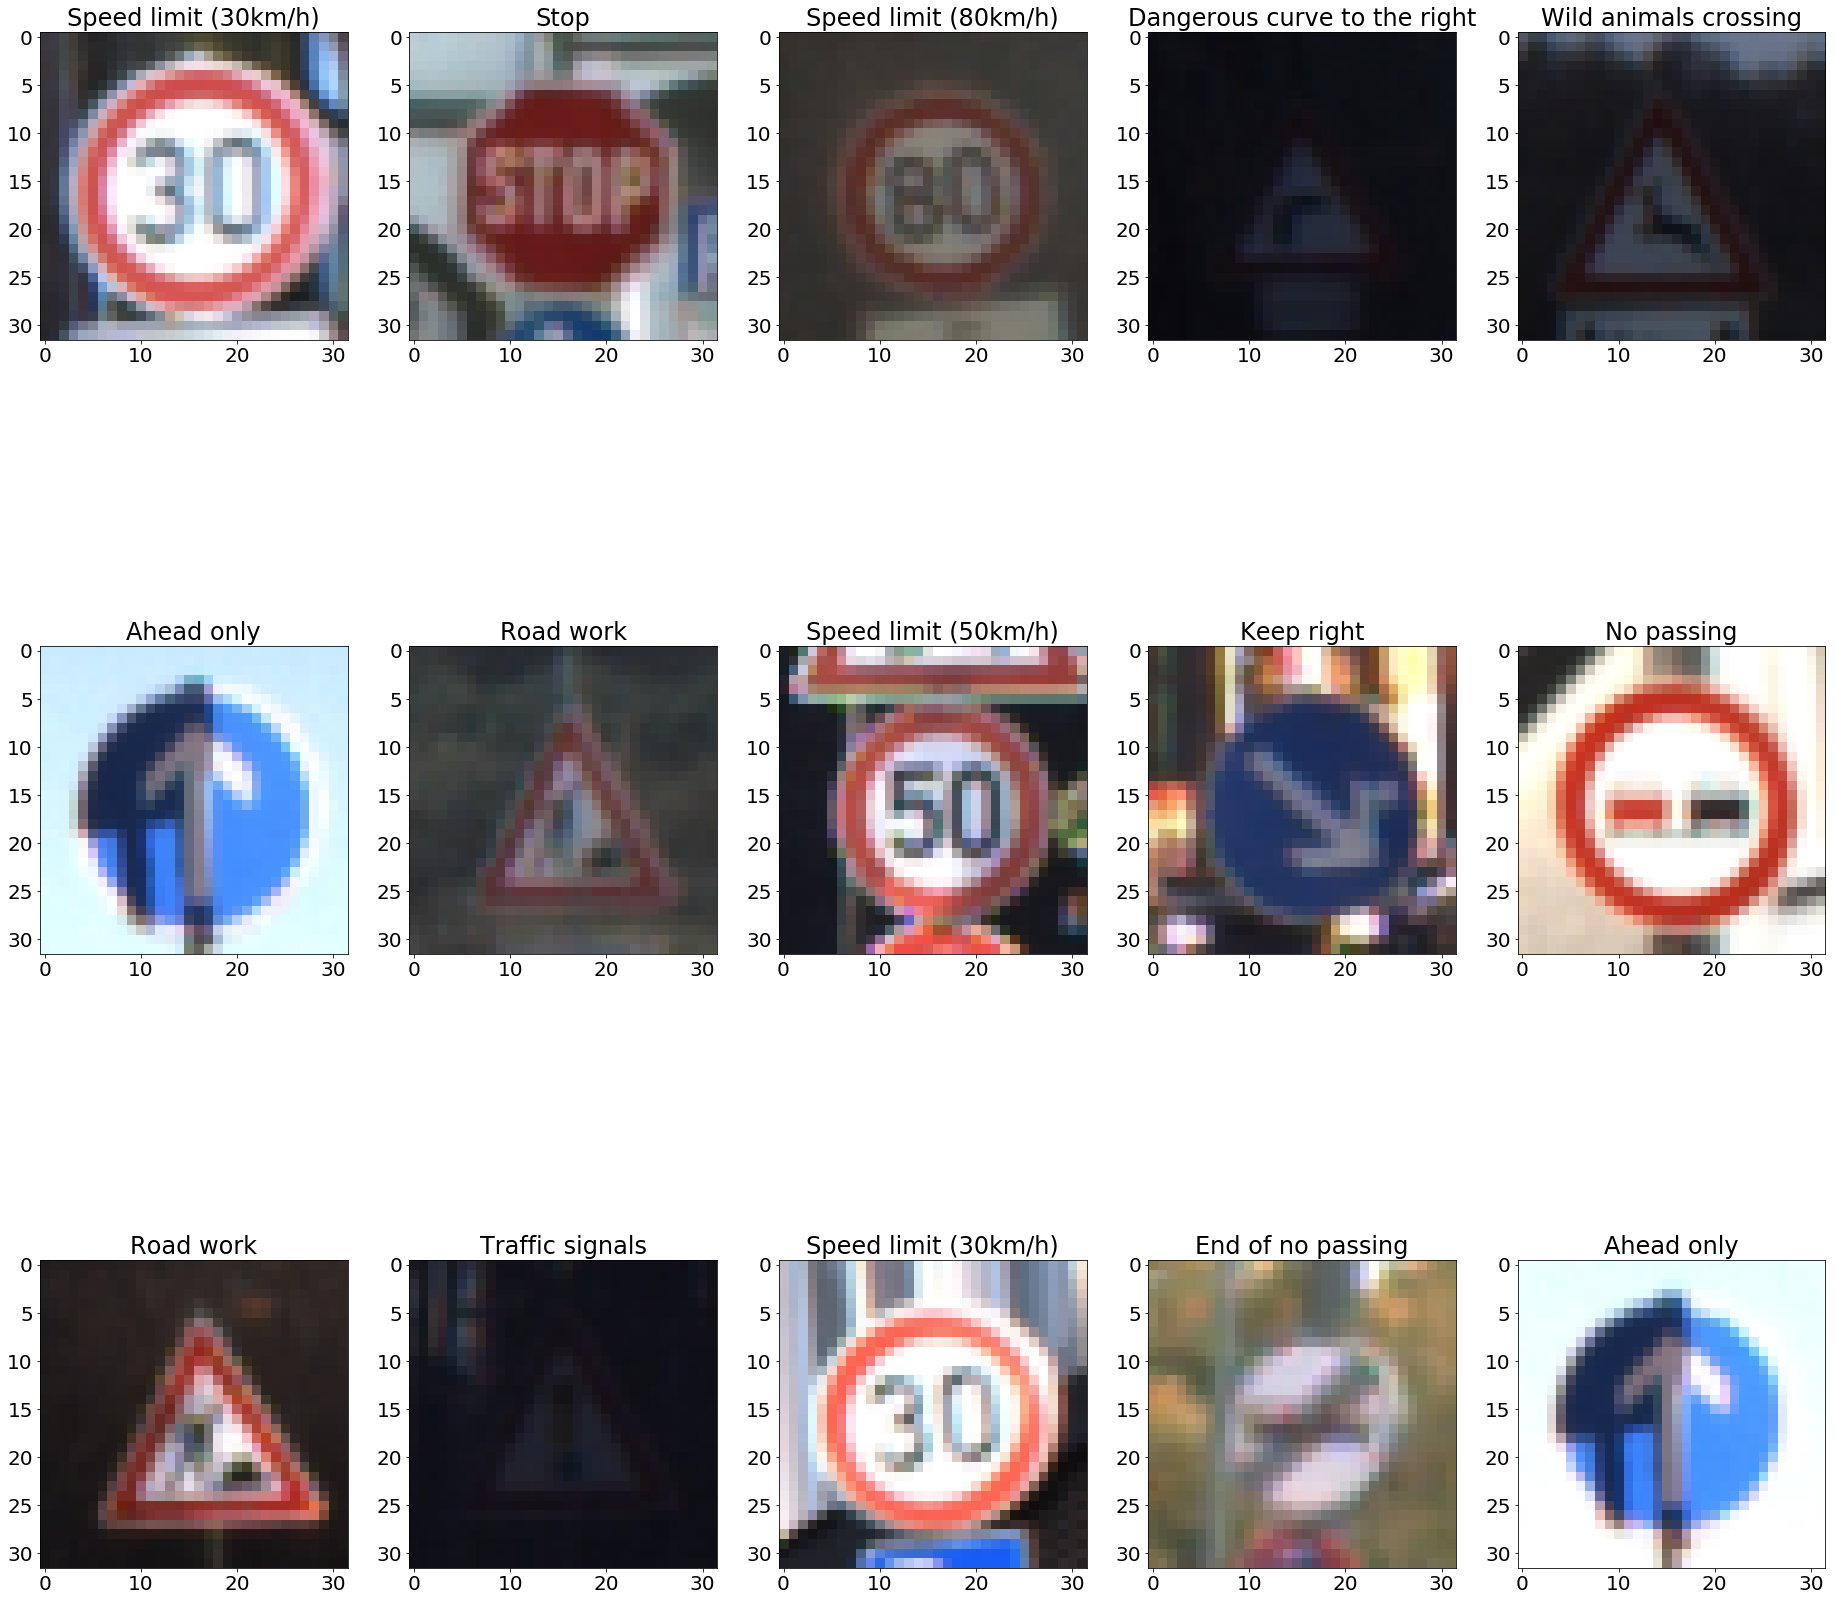

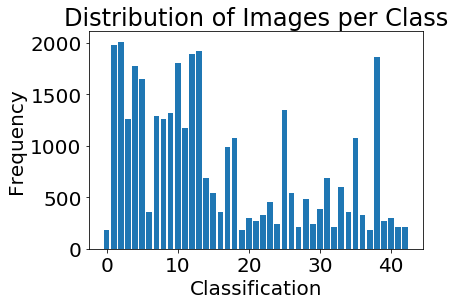

In [2]:
import os
import random
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

cols = 5
rows = 3
img_size = 32
output_dir = "output/"
save_name = "training_data_sample.png"

# Create output directory as needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Show random sample of data with labels
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(rows, cols, figsize=(img_size, img_size))
for row in range(rows):
    for col in range(cols):
        index = random.randint(0, len(X_train))
        ax[row, col].imshow(X_train[index].squeeze())
        title = class_name[y_train[index]]
        ax[row, col].set_title(title)
plt.savefig(output_dir + save_name, bbox_inches='tight')
plt.show()

# Display training set label distribution
save_name = "data_histogram.png"
hist, bins = np.histogram(y_train, bins=n_classes)
plt.bar(range(n_classes), hist)
plt.xlabel("Classification")
plt.ylabel("Frequency")
plt.title("Distribution of Images per Class")
plt.savefig(output_dir + save_name, bbox_inches='tight')
plt.show()

---
## Augment the Data

We can see from the above histogram that the distribution of training images is very uneven.  To prevent the model from just learning the distribution, instead of actually recognizing signs, I will augment the with images of my own so that the distribution is even.  This should also make the model more robust at recognizing perturbed images

In [3]:
# Data Augmentation methods
import cv2
import numpy as np

# Some of these functions are based on the OpenCV 'Geometric Transformations of Images' examples

def random_rotate(img, neg_rotation=-5., pos_rotation=5.):
    # Add a slight rotation
    
    rows, cols, depth = img.shape
    angle = np.random.random_sample() * (abs(neg_rotation - pos_rotation)) - neg_rotation
    out = np.copy(img)

    M = cv2.getRotationMatrix2D((cols/2,rows/2), angle, 1)
    out = cv2.warpAffine(img, M, (cols, rows), borderMode=cv2.BORDER_REFLECT)

    return out

def random_gaussian(img, mu=0.0, sigma=5.0):
    # Add Gaussian noise to an image
    out = np.copy(img.astype(np.float))
    rows, cols, depth = img.shape
    noise = np.random.normal(mu, sigma, (rows, cols))
    for dim in range(depth):
        out[:,:, dim] = img[:,:, dim] + noise
    out[out > 255] = 255
    out[out < 0] = 0
    out = out.astype(np.uint8)
    
    return out

def random_saltpepper(img, percent_to_change=0.01):
    # Add salt and pepper noise to an image
    out = np.copy(img)
    rows, cols, depth = img.shape
    random = np.random.random((rows, cols))
    out[random > (1-percent_to_change), :] = 0
    out[random < percent_to_change, :] = 255
    
    return out
    
def random_scale(img, min_scale=0.8, max_scale=1.2):
    # Randomly scale the image up or down, preserving size
    scale = np.random.random() * abs(min_scale - max_scale) + min_scale
    rows, cols, depth = img.shape
    dim = (int(cols * scale), int(rows * scale))
    if scale < 1:
        out = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
        pad = (img.shape[0] - out.shape[0]) // 2
        remain = (img.shape[0] - out.shape[0]) % 2
        out = cv2.copyMakeBorder(out, pad, pad + remain, pad, pad + remain, borderType=cv2.BORDER_REPLICATE)
    else:
        out = cv2.resize(img, dim, interpolation=cv2.INTER_LINEAR)
        start = out.shape[0] // 2 - img.shape[0] // 2
        end = start + img.shape[0]
        out = out[start:end, start:end, :]
    
    return out    

def random_brightness(img, max_scale=0.2):
    # Linearly increase or decrease pixel values across the image
    scale = (np.random.random() - 0.5) * max_scale + 1.0
    out = np.copy(img.astype(np.float))
    out = out * scale
    out[out > 255] = 255
    out[out < 0] = 0
    out = out.astype(np.uint8)
    
    return out

def random_translation(img, max_tx=5, max_ty=5):
    # Shift image content and fill with reflected border
    rows, cols, depth = img.shape
    tx = np.random.randint(-max_tx, max_tx)
    ty = np.random.randint(-max_ty, max_ty)

    M = np.float32([[1, 0, tx], [0 , 1, ty]])
    out = cv2.warpAffine(img, M, (cols, rows), borderMode=cv2.BORDER_REFLECT)
    
    return out

def random_all(img):
    """Perform all image randomizations
    
    Apply rotation, translation, scale, salt & pepper,
    Gaussian, and brightness randomization to the input image
    
    Input:
        img: input image to be transformed
    
    Output:
        randomly transformed image of same shape as input img
    """
    
    return random_saltpepper(
        random_gaussian(
            random_brightness(
                random_rotate(
                    random_scale(
                        random_translation(img))))))

### Visualize Perturbations

We can visualize the results of each random perturbation to a sample training image.  The augmented data will utilize all of these randomizations 

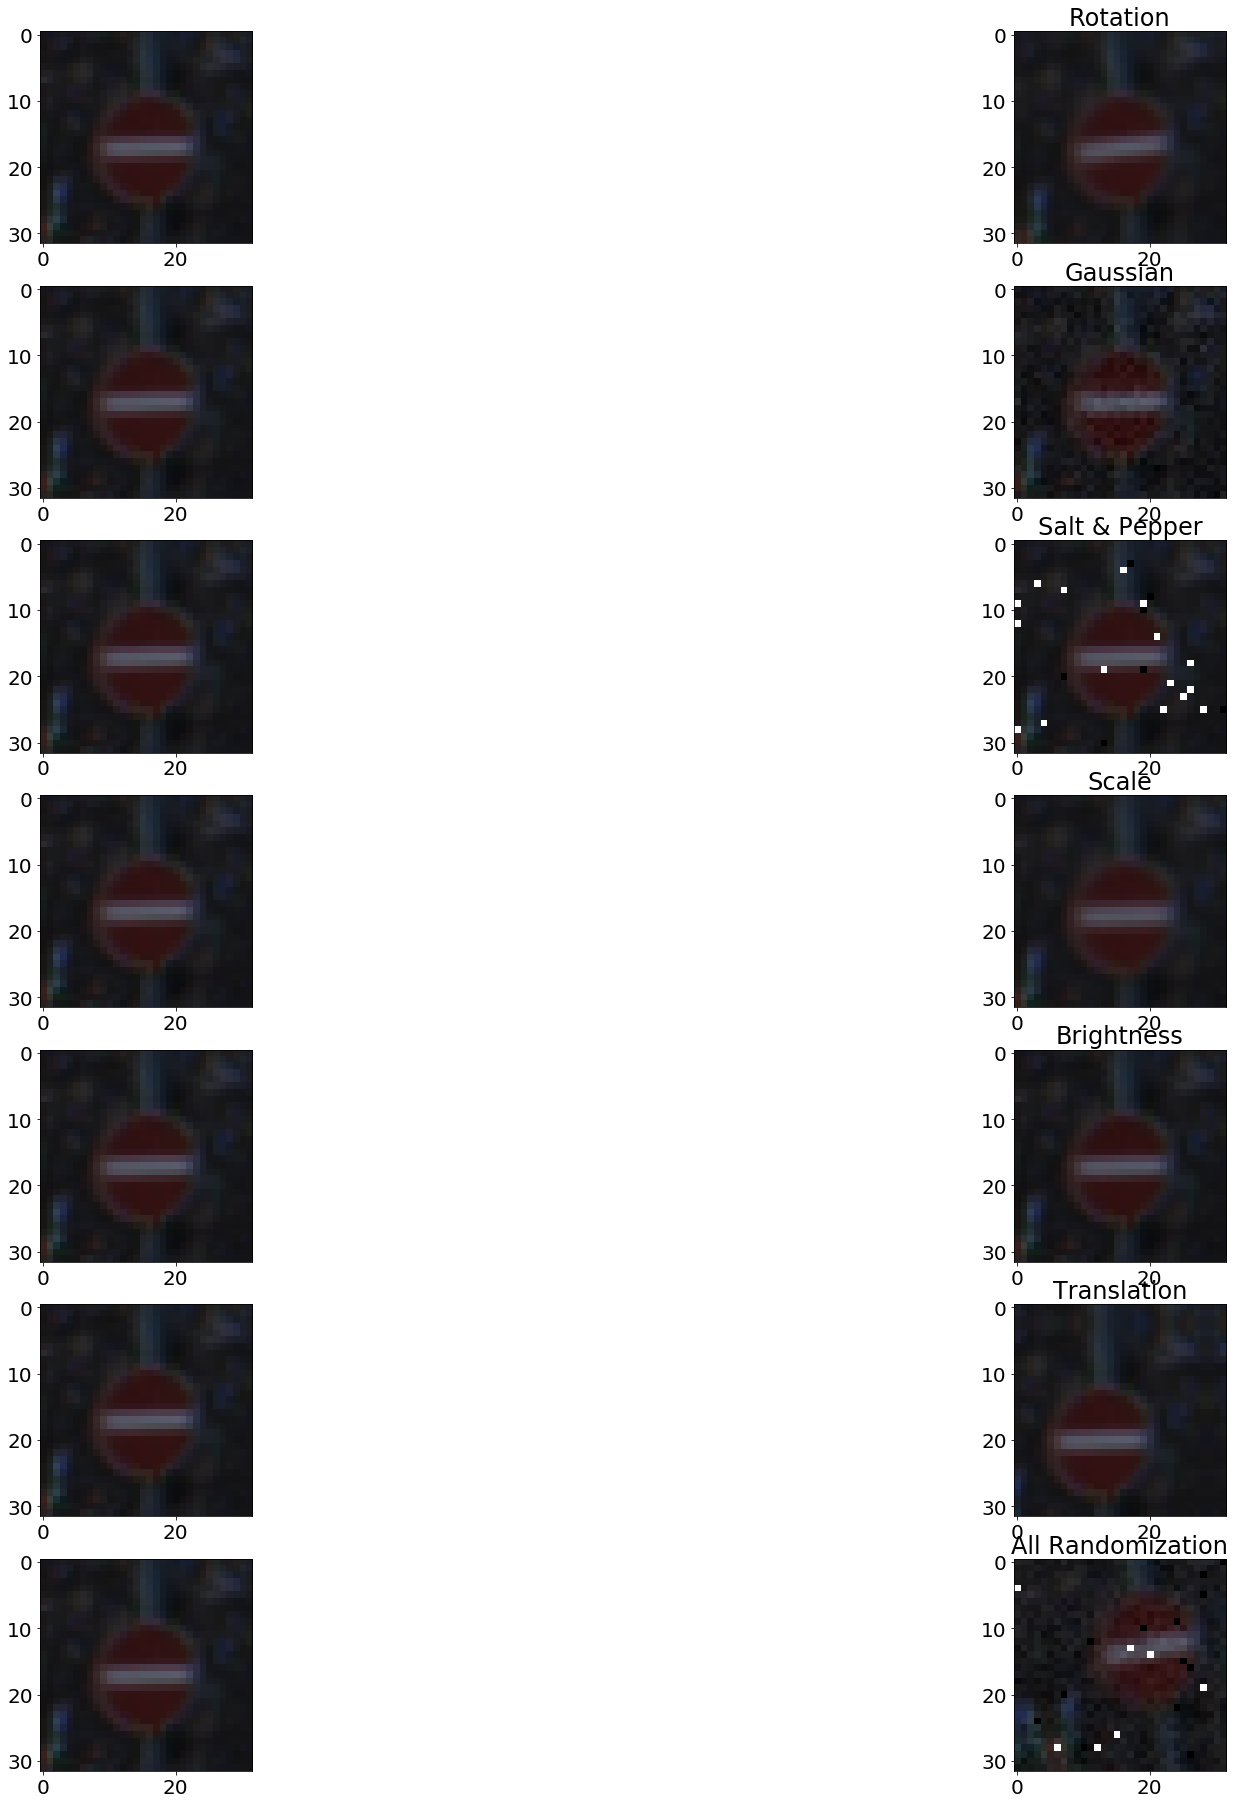

In [4]:
plt.rcParams.update({'font.size': 20})
img_size = 32
img = X_train[np.random.randint(0, X_train.shape[0])]
save_name = "data_augmentation.png"
rows = 7
cols = 2
min_px = 0
max_px = 255

fig, ax = plt.subplots(rows, cols, figsize=(img_size, img_size))
for idx in range(rows):
    ax[idx, 0].imshow(img)
ax[0, 1].imshow(random_rotate(img), vmin=min_px, vmax=max_px)
ax[0, 1].set_title("Rotation")
ax[1, 1].imshow(random_gaussian(img), vmin=min_px, vmax=max_px)
ax[1, 1].set_title("Gaussian")
ax[2, 1].imshow(random_saltpepper(img), vmin=min_px, vmax=max_px)
ax[2, 1].set_title("Salt & Pepper")
ax[3, 1].imshow(random_scale(img), vmin=min_px, vmax=max_px)
ax[3, 1].set_title("Scale")
ax[4, 1].imshow(random_brightness(img), vmin=min_px, vmax=max_px)
ax[4, 1].set_title("Brightness")
ax[5, 1].imshow(random_translation(img), vmin=min_px, vmax=max_px)
ax[5, 1].set_title("Translation")
ax[6, 1].imshow(random_all(img), vmin=min_px, vmax=max_px)
ax[6, 1].set_title("All Randomization")
plt.savefig(output_dir + save_name, bbox_inches='tight')
plt.show()

### Create and Add Augmented Images to Training Data

Now we will actually create the augmented data and append it to the training data.  Augmented images will be added to each class, as needed, so that all of them will have some minimum number of trainable images

In [5]:
# Target number of examples in each class
target_class_size = 500
min_augmentation = 200

# Current number of examples per class
# code sourced from https://stackoverflow.com/questions/28663856/
# how-to-count-the-occurrence-of-certain-item-in-an-ndarray-in-python
unique, counts = np.unique(y_train, return_counts=True)
class_freq = dict(zip(unique, counts))

X_augment = None
y_augment = None
augmented_class_imgs = []
augmented_class_labels = []

for class_id in range(n_classes):
    num_to_add = target_class_size - class_freq[class_id]
    num_to_add = min(num_to_add, min_augmentation)
    if num_to_add <= 0:
        continue
        
    # Find indices for sample source images of this class
    class_imgs_idx = np.where(y_train == class_id)[0]
    source_imgs_idx = np.random.choice(class_imgs_idx, num_to_add)
    
    # Generate randomized images
    for idx in source_imgs_idx:
        transformed_img = random_all(X_train[idx])
        augmented_class_imgs.append(transformed_img)
        augmented_class_labels.append(class_id)

X_augment = np.stack(augmented_class_imgs, axis=0)
y_augment = np.stack(augmented_class_labels, axis=0)

print("Shape of original training data: " + str(X_train.shape))
print("Shape of original training labels: " + str(y_train.shape))
print()
print("Shape of augmented images: " + str(X_augment.shape))
print("Shape of augmented labels: " + str(y_augment.shape))

# Add augmented data to training data
X_train = np.concatenate((X_train, X_augment), axis=0)
y_train = np.concatenate((y_train, y_augment), axis=0)
print()
print("Shape of updated training data: " + str(X_train.shape))
print("Shape of updated training labels: " + str(y_train.shape))

Shape of original training data: (34799, 32, 32, 3)
Shape of original training labels: (34799,)

Shape of augmented images: (3540, 32, 32, 3)
Shape of augmented labels: (3540,)

Shape of updated training data: (38339, 32, 32, 3)
Shape of updated training labels: (38339,)


We should observe a change in the distribution of the training data

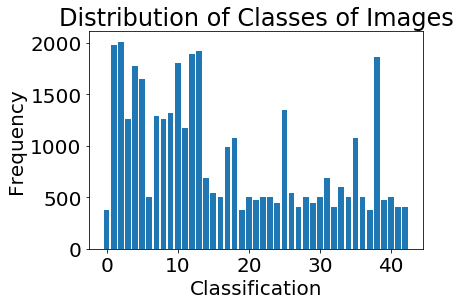

In [6]:
# Display training set label distribution
save_name = "augmented_data_histogram.png"
hist, bins = np.histogram(y_train, bins=n_classes)
plt.bar(range(n_classes), hist)
plt.xlabel("Classification")
plt.ylabel("Frequency")
plt.title("Distribution of Classes of Images")
plt.savefig(output_dir + save_name, bbox_inches='tight')
plt.show()

### Pre-process the Data Set

While images should be normalized to zero mean and equal variance, testing showed that such normalization significantly degraded performance.  Therefore, only data shuffling is used here

In [7]:
from sklearn.utils import shuffle

def normalize(dataset):
    return ((dataset - 128) / 128)

# Shuffle the training data
X_train, y_train = shuffle(X_train, y_train)

---
## Design CNN Architecture

This model is a two layer CNN with two fully connected layers at the top.  It utilizes L2 Regularization and Dropout to improve generalizability.

This [LeCunn paper](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf) helped to inspire some of these design choices

### Model Architecture

In [8]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def cnn(x, keep_prob, num_filters_1=6, num_filters_2=16):
    """Construct two-layer, single stage CNN with 2 fully connected layers
    
        Inputs:
            x: input data of shape 32x32x3
            keep_prob: tf.placeholder with the probability of keeing a
                unit for dropout
            num_filters_1: number of 5x5x3 filters to use in the first layer
            num_filters_2: number of 5x5 filters to use in the second layer
        
        Output:
            Logits 
    
    """

    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
        
    weights = {
        'wc1': tf.Variable(tf.random_normal((5, 5, 3, num_filters_1), mean=mu, stddev=sigma)),
        'wc2': tf.Variable(tf.random_normal((5, 5, num_filters_1, num_filters_2), mean=mu, stddev=sigma)),
        'wf1': tf.Variable(tf.random_normal((5*5*num_filters_2, 120), mean=mu, stddev=sigma)),
        'wf2': tf.Variable(tf.random_normal((120, 84), mean=mu, stddev=sigma)),
        'out': tf.Variable(tf.random_normal((84, 43), mean=mu, stddev=sigma))
    }
    biases = {
        'bc1': tf.Variable(tf.zeros([num_filters_1])),
        'bc2': tf.Variable(tf.zeros([num_filters_2])),
        'bf1': tf.Variable(tf.zeros([120])),
        'bf2': tf.Variable(tf.zeros([84])),
        'out': tf.Variable(tf.zeros([43]))
    }
    
    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28xnum_filters_1.
    conv1 = tf.nn.conv2d(x, weights['wc1'], strides=[1, 1, 1, 1], padding='VALID')
    conv1 = tf.nn.bias_add(conv1, biases['bc1'])    
    
    # TODO: Activation.
    activ1 = tf.nn.relu(conv1)
    activ1 = tf.nn.dropout(activ1, keep_prob)

    # TODO: Pooling. Input = 28x28xnum_filters_1. Output = 14x14xnum_filters_1.
    maxpool1 = tf.nn.max_pool(activ1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # TODO: Layer 2: Convolutional. Output = 10x10xnum_filters_2.
    conv2 = tf.nn.conv2d(maxpool1, weights['wc2'], strides=[1, 1, 1, 1], padding='VALID')
    conv2 = tf.nn.bias_add(conv2, biases['bc2'])
    
    # TODO: Activation.
    activ2 = tf.nn.relu(conv2)
    activ2 = tf.nn.dropout(activ2, keep_prob)

    # TODO: Pooling. Input = 10x10xnum_filters_2. Output = 5x5xnum_filters_2.
    maxpool2 = tf.nn.max_pool(activ2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # TODO: Flatten. Input = 5x5xnum_filters_2. Output = .
    flat = tf.contrib.layers.flatten(maxpool2)
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1 = tf.add(tf.matmul(flat, weights['wf1']), biases['bf1'])
    
    # TODO: Activation.
    fcactiv1 = tf.nn.relu(fc1)
    fcactiv1 = tf.nn.dropout(fcactiv1, keep_prob)

    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2 = tf.add(tf.matmul(fcactiv1, weights['wf2']), biases['bf2'])    
    
    # TODO: Activation.
    fcavtiv2 = tf.nn.relu(fc2)
    fcactiv2 = tf.nn.dropout(fcavtiv2, keep_prob)

    # TODO: Layer 5: Fully Connected. Input = 84. Output = 43.
    out = tf.add(tf.matmul(fcavtiv2, weights['out']), biases['out'])
    logits = out
    
    print("CNN has been constructed with " + str(num_filters_1) + 
          " filters in first layer and " + str(num_filters_2) + " in second")
    
    return logits, weights, biases

### Hyperparameters

In [9]:
EPOCHS = 50
BATCH_SIZE = 128

learning_rate = 0.001
l2_weight = 0.01
dropout_rate = 0.7

In [10]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder(tf.float32)

In [11]:
logits, weights, biases = cnn(x, keep_prob, 38, 64)
# logits, weights, biases = cnn(x, keep_prob, 108, 108)
# logits, weights, biases = cnn(x, keep_prob)

# Technique learned from: https://stackoverflow.com/questions/38286717/
# tensorflow-regularization-with-l2-loss-how-to-apply-to-all-weights-not-just
lossL2 = tf.add_n([ tf.nn.l2_loss(var) for name, var in weights.items()]) * l2_weight

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = (tf.reduce_mean(cross_entropy) + lossL2)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_operation = optimizer.minimize(loss_operation)

CNN has been constructed with 38 filters in first layer and 64 in second


### Model Evaluation

In [12]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train and Validate Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [13]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
        
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: dropout_rate})
            
        training_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy   = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './cnn')
    print("Model saved")

Training...

EPOCH 1 ...
Training Accuracy   = 0.047
Validation Accuracy = 0.048

EPOCH 2 ...
Training Accuracy   = 0.050
Validation Accuracy = 0.048

EPOCH 3 ...
Training Accuracy   = 0.050
Validation Accuracy = 0.048

EPOCH 4 ...
Training Accuracy   = 0.053
Validation Accuracy = 0.054

EPOCH 5 ...
Training Accuracy   = 0.052
Validation Accuracy = 0.054

EPOCH 6 ...
Training Accuracy   = 0.053
Validation Accuracy = 0.054

EPOCH 7 ...
Training Accuracy   = 0.053
Validation Accuracy = 0.054

EPOCH 8 ...
Training Accuracy   = 0.053
Validation Accuracy = 0.054

EPOCH 9 ...
Training Accuracy   = 0.053
Validation Accuracy = 0.054

EPOCH 10 ...
Training Accuracy   = 0.052
Validation Accuracy = 0.054

EPOCH 11 ...
Training Accuracy   = 0.053
Validation Accuracy = 0.054

EPOCH 12 ...
Training Accuracy   = 0.053
Validation Accuracy = 0.054

EPOCH 13 ...
Training Accuracy   = 0.053
Validation Accuracy = 0.054

EPOCH 14 ...
Training Accuracy   = 0.053
Validation Accuracy = 0.054

EPOCH 15 ...
Tra

## Test Model

The test data is only evaluated once, after the model has been finalized and all tuning complete.

In [17]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./cnn
Test Accuracy = 0.947


---

## Test the Model on New Images

To better understand how well the model generalizes, we have downloaded five German traffic signs from the wild web and will attempt to correctly classify them using our trained network

### Load and Visualize the Images

New images tensor: (5, 32, 32, 3)


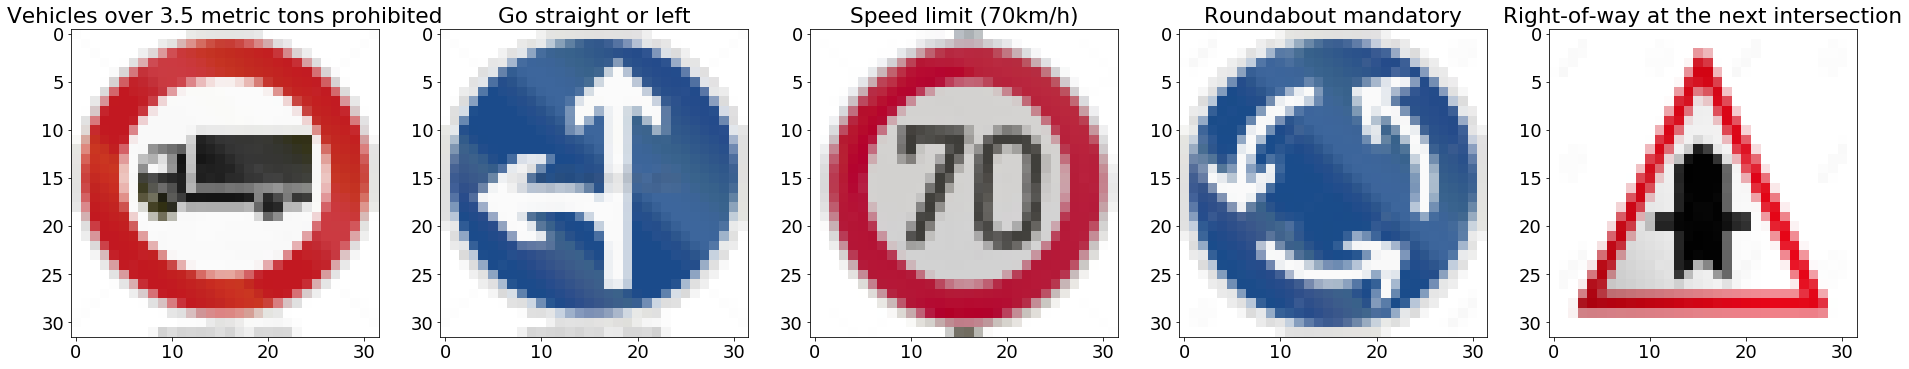

In [14]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import glob
import cv2

# Load new images
img_size = 32
input_source = "new_images/*.jpg"
new_imgs = []

images = sorted(glob.glob(input_source))
for img_path in images:
    img = cv2.imread(img_path)[...,::-1]  # Convert to RGB from BGR
    resized = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_AREA)
    new_imgs.append(resized)

# Change images to TF form
tf_new_imgs = np.stack(new_imgs, axis=0)
print("New images tensor: {}".format(tf_new_imgs.shape))

# Manually select correct classifications for input images
ground_truth = np.array([16, 37, 4, 40, 11])

# Display and save a visualization of new traffic sign data
save_name = "new_signs.png"
img_size = 32
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(1, 5, figsize=(img_size, img_size))
for idx, img in enumerate(new_imgs):
    ax[idx].imshow(img, vmin = 0, vmax = 255)
    title = class_name[ground_truth[idx]]
    ax[idx].set_title(title)
plt.savefig(output_dir + save_name, bbox_inches='tight')
plt.show()

### Predict the Sign Class

In [15]:
# Restore the saved session
# Learned from https://stackoverflow.com/questions/33759623/tensorflow-how-to-save-restore-a-model
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('./cnn.meta')
    saver.restore(sess, './cnn')
    new_img_accuracy = evaluate(tf_new_imgs, ground_truth)
    print("Accuracy of new images: {}".format(new_img_accuracy))

INFO:tensorflow:Restoring parameters from ./cnn
Accuracy of new images: 1.0


### Output Top 5 Softmax Probabilities

INFO:tensorflow:Restoring parameters from ./cnn
TopKV2(values=array([[  9.99863386e-01,   5.65883092e-05,   3.73286821e-05,
          1.50241249e-05,   5.25086762e-06],
       [  9.99963045e-01,   2.98317900e-05,   6.34496746e-06,
          6.93972481e-07,   4.78522786e-08],
       [  5.19387782e-01,   2.92045057e-01,   1.87307447e-01,
          4.73830645e-04,   2.43193135e-04],
       [  9.95559096e-01,   3.21315974e-03,   1.15897576e-03,
          4.97502078e-05,   1.05544150e-05],
       [  9.99747455e-01,   8.38293709e-05,   6.69431029e-05,
          4.29050415e-05,   4.09610111e-05]], dtype=float32), indices=array([[16,  0, 23, 17, 19],
       [37, 34, 40, 36,  0],
       [ 4,  0,  1, 22, 18],
       [40, 34, 37, 39, 36],
       [11, 27, 30, 19, 21]], dtype=int32))


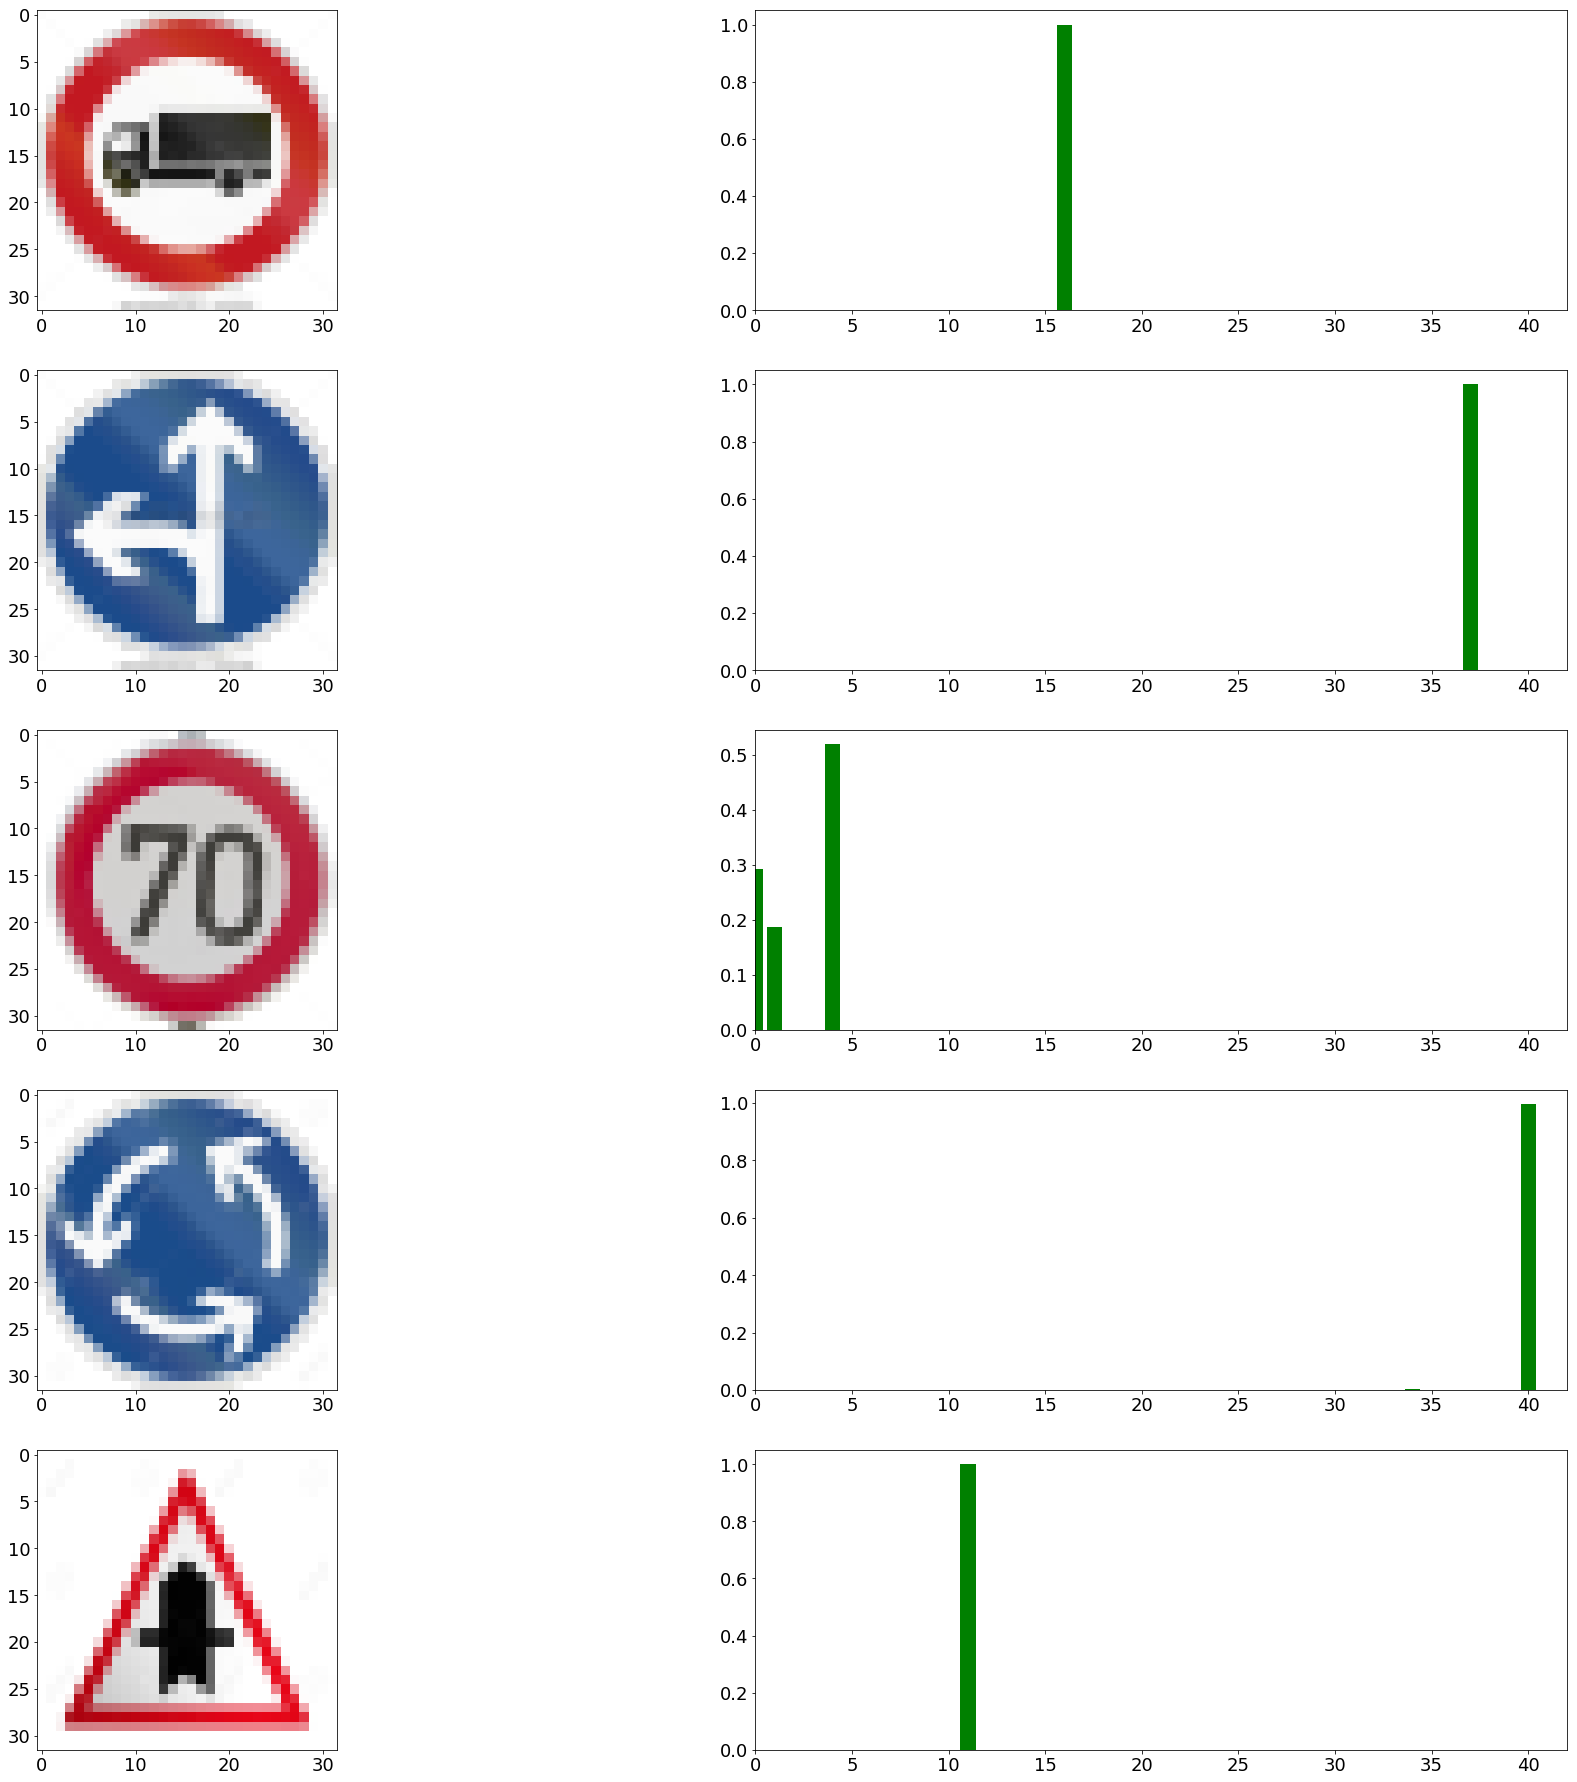

In [16]:
# Print out the top five softmax probabilities for the predictions on
# the German traffic sign images found on the web. 

# Select top 5 softmax
softmax = tf.nn.softmax(logits)
top_5 = tf.nn.top_k(softmax, k=5)

# Run model on new images
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('./cnn.meta')
    saver.restore(sess, './cnn')
    new_img_top_5 = sess.run(top_5, feed_dict={x: tf_new_imgs, keep_prob: 1.0})
    top_5_prob = new_img_top_5[0]
    top_5_class = new_img_top_5[1]
    print(new_img_top_5)
    
    # Display results
    save_name = "new_imgs_softmax.png"
    img_size = 32
    plt.rcParams.update({'font.size': 18})
    fig, ax = plt.subplots(5, 2, figsize=(img_size, img_size))
    
    for idx in range(tf_new_imgs.shape[0]):
        ax[idx, 0].imshow(tf_new_imgs[idx], vmin = -1, vmax = 1)
        ax[idx, 1].bar(top_5_class[idx], top_5_prob[idx], color='green')
        ax[idx, 1].set_xlim([0, 42])
    plt.savefig(output_dir + save_name, bbox_inches='tight')
    plt.show()